# Sprint 5

## Machine Learning - Scratch SVM

### [Problem 1-3] Implement ScratchSVMClassifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter=100, lr=0.01, kernel='linear', threshold=1e-5, verbose=False, gamma=1, d=1, theta0=0):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = gamma
        self.d = d
        self.theta0 = theta0
        self.accuracy_i = []
        self.n_support_i = []
        self.idx_support_i = []
        self.lam_sv_i = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn the SVM classifier. If verification data is input, the accuracy for it is also calculated for each iteration.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        n_samples, n_features = X.shape
        lam = np.ones([n_samples,])
        
        for i in range(self.iter):
            lam = self._lagrange_update(lam, X, y)
            
            self._determine_support_vector(lam, X, y)
            
            if X_val is not None and y_val is not None:
                y_pred = self.predict(X_val)
                self.accuracy_i.append(accuracy_score(y_val, y_pred))
            
            self.n_support_i.append(self.n_support_vectors)
            self.idx_support_i.append(self.index_support_vectors)
            self.lam_sv_i.append(lam)
            
        self._determine_support_vector(lam, X, y)
        
        if self.verbose:
            if X_val is not None and y_val is not None:
                info = pd.DataFrame([self.accuracy_i, self.n_support_i, np.round(self.lam_sv_i, 2)], index=['Accuracy', 'Number of support vectors', 'Lambda'])
            else:
                info = pd.DataFrame([self.n_support_i, np.round(self.lam_sv_i, 2)], index=['Number of support vectors', 'Lambda'])
            print('[VERBOSE RESULT]')
            display(info.T)
    
    def predict(self, X):
        """
        Estimate the label using the SVM classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result by SVM classifier
        """
        n_samples = X.shape[0]
        
        y_pred = ((self.lam_sv * self.y_sv).reshape(-1, 1) * self._kernel_function(X, self.X_sv)).sum(axis=0)
                    
        return np.where(y_pred <= 0, -1, 1)
    
    def _lagrange_update(self, lam, X, y):
        n_samples = X.shape[0]
        
        lam_new = lam + self.lr * (1 - ((lam * y.reshape(-1, 1) * y) * self._kernel_function(X, X)).sum(axis=1))
                
        return np.where(lam_new >= 0, lam_new, 0)
    
    def _kernel_function(self, Xi, Xj):
        return np.dot(Xj, Xi.T) if self.kernel=='linear' else (self.gamma * np.dot(Xj, Xi.T) + self.theta0) ** self.d
    
    def _determine_support_vector(self, lam, X, y):
        self.index_support_vectors = np.where(lam > self.threshold)[0]
        self.n_support_vectors = len(self.index_support_vectors)
        self.X_sv = X[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        self.lam_sv = lam[self.index_support_vectors]

### [Problem 1] Lagrange's steepest descent by the undetermined multiplier method

In [3]:
X = np.array([
    [1, 2, 3],
    [0.4, 1.4, 2.1],   #unreliable record
    [1.5, 2.5, 3.2],
    [2, 3.1, 4.2],
    [1, 1.8, 2.5]
])
X.shape

(5, 3)

In [4]:
y = np.array([1, 1, -1, -1, 1])
y.shape

(5,)

In [5]:
lam = np.array([1, 1, 1, 1, 1])
lam.shape

(5,)

Create matrix A where $a_{ij} = \lambda_{j} y_{i} y_{j}$

In [6]:
lam[3] * y[2] * y[3]

1

In [7]:
lam * y.reshape(-1, 1) * y

array([[ 1,  1, -1, -1,  1],
       [ 1,  1, -1, -1,  1],
       [-1, -1,  1,  1, -1],
       [-1, -1,  1,  1, -1],
       [ 1,  1, -1, -1,  1]])

Create matrix B where $b_{ij} = k(x_{i}, x_{j})$

In [8]:
np.dot(X[2], X[3])  #same as X2.T * X3

24.19

In [9]:
np.dot(X, X.T)

array([[14.  ,  9.5 , 16.1 , 20.8 , 12.1 ],
       [ 9.5 ,  6.53, 10.82, 13.96,  8.17],
       [16.1 , 10.82, 18.74, 24.19, 14.  ],
       [20.8 , 13.96, 24.19, 31.25, 18.08],
       [12.1 ,  8.17, 14.  , 18.08, 10.49]])

We have $\sum_{j=1}^{k} \lambda_{j} y_{i} y_{j} k(x_{i}, x_{j}) = \sum_{j=1}^{k} a_{ij} b_{ij}$

To iterate j from 0 to n, we can use `np.sum()` with `axis=1`.

In [10]:
(lam * y.reshape(-1, 1) * y) * np.dot(X, X.T)

array([[ 14.  ,   9.5 , -16.1 , -20.8 ,  12.1 ],
       [  9.5 ,   6.53, -10.82, -13.96,   8.17],
       [-16.1 , -10.82,  18.74,  24.19, -14.  ],
       [-20.8 , -13.96,  24.19,  31.25, -18.08],
       [ 12.1 ,   8.17, -14.  , -18.08,  10.49]])

In [11]:
res = ((lam * y.reshape(-1, 1) * y) * np.dot(X, X.T)).sum(axis=1)
res

array([-1.3 , -0.58,  2.01,  2.6 , -1.32])

Test the result.

In [12]:
total_i3 = (lam[0] * y[3] * y[0] * np.dot(X[3], X[0])
           + lam[1] * y[3] * y[1] * np.dot(X[3], X[1])
           + lam[2] * y[3] * y[2] * np.dot(X[3], X[2])
           + lam[3] * y[3] * y[3] * np.dot(X[3], X[3])
           + lam[4] * y[3] * y[4] * np.dot(X[3], X[4]))
total_i3

2.599999999999998

In [13]:
np.isclose(total_i3, res[3])

True

Get updated lambda.

In [14]:
lam_new = lam + 0.01 * (1 - res)
lam_new

array([1.023 , 1.0158, 0.9899, 0.984 , 1.0232])

Test multiple iterations.

In [15]:
for i in range(1000):
    lam_new = lam + 0.01 * (1 - ((lam * y.reshape(-1, 1) * y) * np.dot(X, X.T)).sum(axis=1))
    lam = np.where(lam_new >= 0, lam_new, 0)
print(lam)

[ 4.52257553  0.          5.77458664  4.4792071  10.22441229]


Since the lamda at index 1 has unreliable record, so it cannot be included in support vectors.

In [16]:
threshold = 1e-5
index_support_vectors = np.where(lam > threshold)[0]
index_support_vectors

array([0, 2, 3, 4], dtype=int64)

In [17]:
n_support_vectors = len(index_support_vectors)
n_support_vectors

4

In [18]:
X_sv = X[index_support_vectors]
X_sv

array([[1. , 2. , 3. ],
       [1.5, 2.5, 3.2],
       [2. , 3.1, 4.2],
       [1. , 1.8, 2.5]])

In [19]:
y_sv = y[index_support_vectors]
y_sv

array([ 1, -1, -1,  1])

In [20]:
lam_sv = lam[index_support_vectors]
lam_sv

array([ 4.52257553,  5.77458664,  4.4792071 , 10.22441229])

### [Problem 3] Estimation

In [21]:
X_test = np.array([
    [3, 3, 4],
    [1, 2, 3],
    [2, 2.7, 3.4],
    [2, 3, 4],
    [0.9, 2.2, 2.7]
])

In [22]:
y_test = np.array([-1, 1, -1, -1, 1])

Create matrix A where $a_{in} = k(x_{i}, s_{n}) $

In [23]:
np.dot(X_sv, X_test.T)

array([[21.  , 14.  , 17.6 , 20.  , 13.4 ],
       [24.8 , 16.1 , 20.63, 23.3 , 15.49],
       [32.1 , 20.8 , 26.65, 30.1 , 19.96],
       [18.4 , 12.1 , 15.36, 17.4 , 11.61]])

Create 1D-matrix B where $b_{n} = \lambda_{n} y_{sv_ n}$

In [24]:
lam_sv * y_sv

array([ 4.52257553, -5.77458664, -4.4792071 , 10.22441229])

We have $\sum_{n=1}^{N} = \lambda_{n} y_{sv_ n} k(x_{i}, s_{n}) = b_{n}^{T} * a_{in}$

Get each sample result by using `np.sum()` on `axis=1`

In [25]:
(lam_sv * y_sv).reshape(-1, 1) * np.dot(X_sv, X_test.T)

array([[  94.97408608,   63.31605739,   79.59732929,   90.45151056,
          60.60251207],
       [-143.20974865,  -92.97084489, -119.12972236, -134.54786869,
         -89.44834704],
       [-143.78254776,  -93.16750758, -119.37086909, -134.82413357,
         -89.40497362],
       [ 188.12918606,  123.71538866,  157.04697271,  177.90477378,
         118.70542664]])

In [26]:
y_pred = ((lam_sv * y_sv).reshape(-1, 1) * np.dot(X_sv, X_test.T)).sum(axis=0)
y_pred

array([-3.88902426,  0.89309358, -1.85628945, -1.01571792,  0.45461805])

In [27]:
total_i1 = (lam_sv[0] * y_sv[0] * np.dot(X_test[1], X_sv[0])
           + lam_sv[1] * y_sv[1] * np.dot(X_test[1], X_sv[1])
           + lam_sv[2] * y_sv[2] * np.dot(X_test[1], X_sv[2])
           + lam_sv[3] * y_sv[3] * np.dot(X_test[1], X_sv[3]))
total_i1

0.8930935797144883

In [28]:
y_result = np.where(y_pred >= 0, 1, -1)
y_result

array([-1,  1, -1, -1,  1])

In [29]:
scratch_svm = ScratchSVMClassifier(num_iter=1000, verbose=True)
scratch_svm.fit(X, y, X_test, y_test)

[VERBOSE RESULT]


,Accuracy,Number of support vectors,Lambda
0,0.6,5,"[1.02, 1.02, 0.99, 0.98, 1.02]"
1,1.0,5,"[1.03, 1.02, 0.99, 0.99, 1.04]"
2,1.0,5,"[1.04, 1.03, 1.0, 0.99, 1.05]"
3,1.0,5,"[1.05, 1.03, 1.01, 1.0, 1.06]"
4,1.0,5,"[1.06, 1.04, 1.02, 1.01, 1.07]"
...,...,...,...
995,1.0,4,"[4.52, 0.0, 5.76, 4.47, 10.19]"
996,1.0,4,"[4.52, 0.0, 5.76, 4.47, 10.2]"
997,1.0,4,"[4.52, 0.0, 5.77, 4.47, 10.21]"
998,1.0,4,"[4.52, 0.0, 5.77, 4.48, 10.22]"


### [Problem 4] Learning and estimation

In [30]:
import numpy as np
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(375, 2)

(125, 2)

(375,)

(125,)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

In [33]:
scratch_svm = ScratchSVMClassifier(num_iter=1000, lr=0.001, verbose=True)
scratch_svm.fit(X_train_scaled, y_train)
scratch_svm_predict = scratch_svm.predict(X_test_scaled)

pd.DataFrame([scratch_svm_predict, y_test], index=['Predict value', 'Actual value'])

[VERBOSE RESULT]


,Number of support vectors,Lambda
0,375,"[0.42, 0.37, 0.4, 0.32, 0.41, 0.58, 0.48, 0.51..."
1,348,"[0.16, 0.09, 0.13, 0.02, 0.14, 0.39, 0.25, 0.3..."
2,287,"[0.05, 0.0, 0.01, 0.0, 0.02, 0.31, 0.14, 0.2, ..."
3,234,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.26, 0.08, 0.14, 0...."
4,196,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.04, 0.1, 0.0..."
...,...,...
995,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
996,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
997,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
998,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
Predict value,1,-1,-1,-1,-1,1,-1,-1,1,1,...,-1,-1,-1,1,1,-1,1,1,-1,-1
Actual value,1,-1,-1,-1,-1,1,-1,-1,1,1,...,-1,-1,-1,1,1,-1,1,1,-1,-1


In [34]:
print(classification_report(scratch_svm_predict, y_test))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        62

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



In [35]:
svc = SVC()
svc.fit(X_train, y_train)
svc_predict = svc.predict(X_test)

pd.DataFrame([scratch_svm_predict, y_test], index=['Predict value', 'Actual value'])

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
Predict value,1,-1,-1,-1,-1,1,-1,-1,1,1,...,-1,-1,-1,1,1,-1,1,1,-1,-1
Actual value,1,-1,-1,-1,-1,1,-1,-1,1,1,...,-1,-1,-1,1,1,-1,1,1,-1,-1


In [36]:
print(classification_report(scratch_svm_predict, y_test))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        62

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



### [Problem 5] Visualization of decision area

In [37]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, Xh=None, support_indices=[], step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    Draw the determination area of the model that learned binary classification with two-dimensional features.
    The background color is drawn from the estimated values of the trained model.
    The points on the scatter plot are training or validation data.
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        Feature value
    y : ndarray, shape(n_samples,)
        label
    model : object
        Insert the installed model of the learned model
    step : float, (default : 0.1)
        Set the interval to calculate the estimate
    title : str
        Give the text of the graph Title
    xlabel, ylabel : str
        Give the text of the axis label
    target_names= : list of str
        Give a list of legends
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    if Xh is not None:
        plt.scatter(Xh[:, 0], Xh[:, 1], s=80, color='y', label='support', marker='o')
    
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

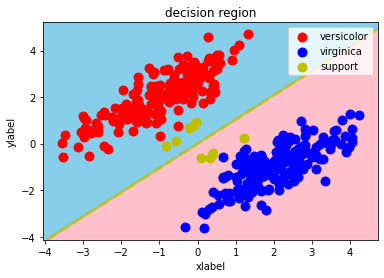

In [38]:
decision_region(X_train, y_train, scratch_svm, Xh=scratch_svm.X_sv)

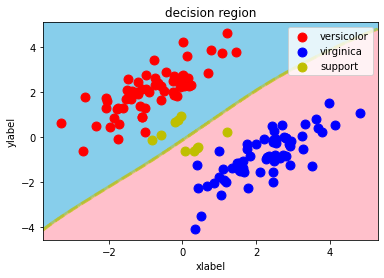

In [39]:
decision_region(X_test, y_test, svc, Xh=scratch_svm.X_sv)

### [Problem 6] (Advance task) Creation of polynomial kernel function

In [40]:
scratch_svm_poly = ScratchSVMClassifier(num_iter=1000, lr=0.001, verbose=True, kernel='poly', d=2, gamma=2, theta0=0.5)
scratch_svm_poly.fit(X_train_scaled, y_train)

[VERBOSE RESULT]


,Number of support vectors,Lambda
0,137,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.17, 0.0, 0.02, 0.0..."
1,153,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.11, 0.0, 0.0, 0.0..."
2,102,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.0, 0.0, 0.0,..."
3,90,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0,..."
4,81,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0,..."
...,...,...
995,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
996,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
997,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
998,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [41]:
scratch_svm_poly_predict = scratch_svm_poly.predict(X_test_scaled)

pd.DataFrame([scratch_svm_poly_predict, y_test], index=['Predict value', 'Actual value'])

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
Predict value,1,-1,-1,-1,-1,1,-1,-1,1,1,...,-1,-1,-1,1,1,-1,1,1,-1,-1
Actual value,1,-1,-1,-1,-1,1,-1,-1,1,1,...,-1,-1,-1,1,1,-1,1,1,-1,-1


In [42]:
print(classification_report(scratch_svm_poly_predict, y_test))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        62

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

